In [8]:
import evaluate
import numpy as np
import pandas as pd
import tensorflow as tf
from datasets import Dataset
from transformers import RobertaTokenizerFast, DataCollatorWithPadding, create_optimizer, TFAutoModelForSequenceClassification
from transformers.keras_callbacks import KerasMetricCallback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from utils import stratified_split, get_x_y, MAX_SEQ_LEN

RuntimeError: Failed to import transformers.optimization_tf because of the following error (look up to see its traceback):
cannot import name 'convert_batch_encoding' from 'transformers.tf_utils' (/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/transformers/tf_utils.py)

In [2]:
model_handle = 'FacebookAI/roberta-base'

In [3]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [4]:
train_set, valid_set, test_set = stratified_split(df)
train_set = train_set.drop(['title', 'preprocessed_text'], axis=1)
test_set = test_set.drop(['title', 'preprocessed_text'], axis=1)
valid_set = valid_set.drop(['title', 'preprocessed_text'], axis=1)
train_set = train_set.rename(columns={'generated': 'label'})
test_set = test_set.rename(columns={'generated': 'label'})
valid_set = valid_set.rename(columns={'generated': 'label'})

In [5]:
train_dataset = Dataset.from_pandas(train_set)
test_dataset = Dataset.from_pandas(test_set)
valid_dataset = Dataset.from_pandas(valid_set)

In [6]:
tokenizer = RobertaTokenizerFast.from_pretrained(model_handle)

/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
def preprocess_function(examples):

    return tokenizer(examples['text'], truncation=True)

In [8]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/90000 [00:00<?, ? examples/s]

Map: 100%|██████████| 30000/30000 [00:03<00:00, 8573.89 examples/s]


In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [10]:
accuracy = evaluate.load("accuracy")

In [11]:
def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

In [12]:
id2label = {0: "human", 1: "generated"}

label2id = {"human": 0, "generated": 1}

In [13]:
model_name = 'roberta-base'
params_dict = {'learning_rate': 3e-5,
                'epochs': 3,
                'batch': 16,
                }

batches_per_epoch = len(tokenized_train) // params_dict['batch']

total_train_steps = int(batches_per_epoch * params_dict['epochs'])

optimizer, schedule = create_optimizer(init_lr=params_dict['learning_rate'], num_warmup_steps=0, num_train_steps=total_train_steps)

2024-05-05 10:24:50.846294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 10:24:50.847977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 10:24:50.850635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [14]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_handle,
                                                             num_labels=2, 
                                                             id2label=id2label, 
                                                             label2id=label2id)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [15]:
tf_train_set = model.prepare_tf_dataset(

    tokenized_train,

    shuffle=True,

    batch_size=params_dict['batch'],

    collate_fn=data_collator,

)

tf_validation_set = model.prepare_tf_dataset(

    tokenized_valid,

    shuffle=True,

    batch_size=params_dict['batch'],

    collate_fn=data_collator,

)

tf_test_set = model.prepare_tf_dataset(

    tokenized_test,

    shuffle=False,

    batch_size=params_dict['batch'],

    collate_fn=data_collator,

)

In [16]:
# no loss because Transformers models all have a default task-relevant loss function
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))

In [17]:
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [18]:
tf.config.run_functions_eagerly(True)

In [19]:
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=params_dict['epochs'], callbacks=[metric_callback])
model.save('models/roberta-base.keras')

Epoch 1/3


5625/5625 [==============================] - 5006s 889ms/step - loss: 4.1249 - val_loss: 7.6666 - accuracy: 0.5000


2024-05-05 11:48:22.780585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/3
5625/5625 [==============================] - 5005s 890ms/step - loss: 5.9819 - val_loss: 7.6666 - accuracy: 0.5000
Epoch 3/3


2024-05-05 13:12:43.441134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


5625/5625 [==============================] - 5061s 900ms/step - loss: 7.6667 - val_loss: 7.6667 - accuracy: 0.5000


2024-05-05 14:37:04.754742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [27]:
import matplotlib.pyplot as plt

In [20]:
y_preds = model.predict(tf_test_set)

1875/1875 [==============================] - 281s 150ms/step


In [22]:
y_preds

TFSequenceClassifierOutput(loss=None, logits=array([[1.7301762, 1.9040337],
       [1.5871149, 1.8031362],
       [1.7282065, 1.9030381],
       ...,
       [1.7295307, 1.9036435],
       [1.5898966, 1.7940159],
       [1.7267476, 1.9023468]], dtype=float32), hidden_states=None, attentions=None)

In [29]:
preds = np.argmax(y_preds.logits, axis=1)

In [34]:
print(classification_report(np.array(test_set['label'].values), preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15000
           1       0.50      1.00      0.67     15000

    accuracy                           0.50     30000
   macro avg       0.25      0.50      0.33     30000
weighted avg       0.25      0.50      0.33     30000



/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [23]:
tf_train_set

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(16, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(16,), dtype=tf.int64, name=None))>

In [24]:
from transformers import pipeline

In [25]:
classifier = pipeline("text-classification", model=model)

Exception: Impossible to guess which tokenizer to use. Please provide a PreTrainedTokenizer class or a path/identifier to a pretrained tokenizer.

In [ ]:
#probaj s preprocessed

# New RoBERTa
https://www.kaggle.com/code/dimasmunoz/text-classification-with-roberta-and-tpus#Dataset-analysis

In [1]:
import numpy as np
import pandas as pd

from utils import stratified_split, get_x_y

from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

2024-05-06 11:43:13.900656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 11:43:13.900707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 11:43:13.902117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 11:43:13.910230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 11:43:14.765295: W tensorflow/compiler/tf2

In [4]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [22]:
MAX_SEQ_LEN = 128
MODEL_NAME = 'roberta-base'

params_dict = {'learning_rate': 3e-5,
                'epochs': 3,
                'batch': 16,
                }

In [3]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [4]:
# split data
train_set, valid_set, test_set = stratified_split(df)
x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

x_train = x_train.values
x_test = x_test.values
x_valid = x_valid.values

In [23]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_SEQ_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_SEQ_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_SEQ_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_SEQ_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_SEQ_LEN else MAX_SEQ_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [6]:
category_to_id = {'human': 0, 'generated': 1}
category_to_name = {0: 'human', 1: 'generated'}

In [7]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
X_train = roberta_encode(x_train, tokenizer)
X_test = roberta_encode(x_test, tokenizer)
X_valid = roberta_encode(x_valid, tokenizer)

In [25]:
def build_model(params_dict):
    input_word_ids = tf.keras.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_type_ids')

    # Import RoBERTa model from HuggingFace
    roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
    x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

    # Huggingface transformers have multiple outputs, embeddings are the first one,
    # so let's slice out the first position
    x = x[0]

    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='softmax')(x) # 1 because we have binary classification

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params_dict['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [26]:
model = build_model(params_dict)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

In [28]:
history = model.fit(X_train,
                    y_train,
                    epochs=params_dict['epochs'],
                    batch_size=params_dict['batch'],
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Epoch 1/3
5625/5625 [==============================] - 14423s 3s/step - loss: 0.1153 - accuracy: 0.5000 - val_loss: 0.1141 - val_accuracy: 0.5000
Epoch 2/3
 274/5625 [>.............................] - ETA: 3:27:11 - loss: 0.0513 - accuracy: 0.5023

KeyboardInterrupt: 

# RoBERTa Chat

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from utils import get_x_y, stratified_split

2024-05-07 14:35:42.583879: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 14:35:42.620943: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 14:35:42.622053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 14:35:43.344079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
model_name = "roberta-base"
MAX_SEQ_LEN = 128
num_labels = 2

params_dict = {'learning_rate': 1e-5,
                'epochs': 3,
                'batch': 16,
                }

In [3]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [4]:
# split data
train_set, valid_set, test_set = stratified_split(df)
# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

x_train = x_train.values.tolist()
x_test = x_test.values.tolist()
x_valid = x_valid.values.tolist()

In [5]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_name)

/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
tokenized_train = tokenizer(x_train, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')
tokenized_valid = tokenizer(x_valid, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')
tokenized_test = tokenizer(x_test, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')

In [11]:
# Build the RoBERTa model for sequence classification
roberta = TFRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 mode

In [60]:
input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = roberta(input_ids, attention_mask=mask)[0]

# X = tf.keras.layers.Activation("relu")(embeddings)
# X = tf.keras.layers.Dense(128)(X)
# X = tf.keras.layers.Dropout(0.1)(embeddings)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(embeddings)
# y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(embeddings)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
#model.layers[2].trainable = False
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246471   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    70         'attention_mask[0][0]']      
 SequenceClassification)     2),                                                            

In [61]:
optimizer =  Adam(learning_rate=params_dict['learning_rate'])
loss = BinaryCrossentropy()
acc = BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [62]:
# Train the model
history = model.fit((tokenized_train['input_ids'], tokenized_train['attention_mask']), 
                    y_train,
                    validation_data=((tokenized_valid['input_ids'], tokenized_valid['attention_mask']), y_valid),
                    epochs=params_dict['epochs'], 
                    batch_size=params_dict['batch'])

Epoch 1/3


10/10 [==============================] - 50s 3s/step - loss: 0.6852 - accuracy: 0.5133 - val_loss: 0.6569 - val_accuracy: 0.5600
Epoch 2/3
10/10 [==============================] - 26s 3s/step - loss: 0.6110 - accuracy: 0.7600 - val_loss: 0.5457 - val_accuracy: 0.8800
Epoch 3/3
10/10 [==============================] - 25s 2s/step - loss: 0.4726 - accuracy: 0.8800 - val_loss: 0.5100 - val_accuracy: 0.7800


In [ ]:
model.save('models/roberta_latest.h5')

/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#reloaded = tf.keras.models.load_model(('models/roberta_sm.h5'), custom_objects={'TFRobertaForSequenceClassification': TFRobertaForSequenceClassification})

In [15]:
def get_predictions(model, tokenized_x_test):
    predictions = model.predict(dict(tokenized_x_test))
    predictions = np.where(predictions.max(axis=-1) > 0.5, 1, 0)
    return predictions

def acc_loss(history):
    # Visualize Loss & Accuracy

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(np.array(y_true), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def validate_model_roberta(roberta, history, tokenized_x_test, y_true):
    print('#### VALIDATION ####')
    acc_loss(history)

    y_pred = get_predictions(roberta, tokenized_x_test)
    print('Classification report:')
    print(classification_report(y_true, y_pred, zero_division=0))

    conf_matrix(y_true, y_pred)

#### VALIDATION ####


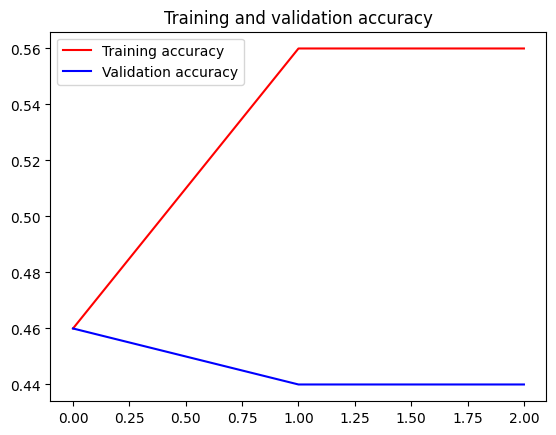

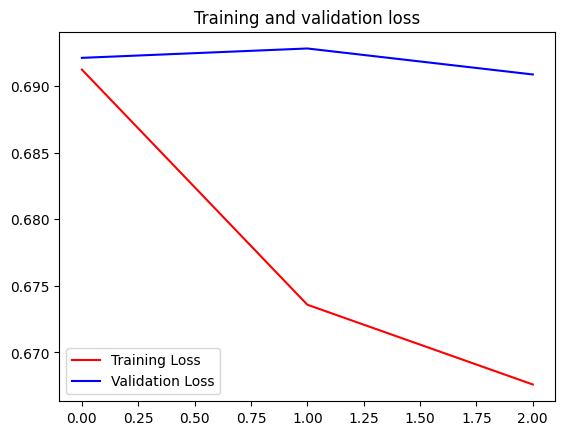

2/2 [==============================] - 5s 905ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        28
           1       0.00      0.00      0.00        22

    accuracy                           0.56        50
   macro avg       0.28      0.50      0.36        50
weighted avg       0.31      0.56      0.40        50



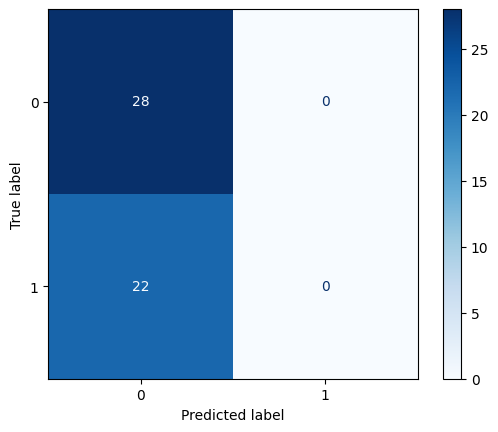

In [50]:
validate_model_roberta(model, history, tokenized_test, y_test)